<a href="https://colab.research.google.com/github/tallpress/fastai/blob/master/pets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Which pet?

These lines will plot matplotlib inline and reload code when it changes

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline



Import fastai

In [0]:
from fastai import *
from fastai.vision import *

Get the pets dataset, data comes with fastai. Contains images of cats and dogs

In [0]:
path = untar_data(URLs.PETS); path

PosixPath('/root/.fastai/data/oxford-iiit-pet')

Shows the files we have, images and annotations. Go on to inpsect the files




In [0]:
path.ls()

[PosixPath('/root/.fastai/data/oxford-iiit-pet/annotations'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images')]

In [0]:
path_anno = path/'annotations'
path_img = path/'images'

In [0]:
fnames = get_image_files(path_img)
fnames[:5]

[PosixPath('/root/.fastai/data/oxford-iiit-pet/images/american_bulldog_71.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/basset_hound_62.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_83.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_106.jpg'),
 PosixPath('/root/.fastai/data/oxford-iiit-pet/images/havanese_58.jpg')]

Create the regex expression used to label the images of the pets. The regex is ran on the file name, and extracts the bread of the pet, and labels the image during the creation of the ImageDataBunch.

In [0]:
np.random.seed(2)
pat = r'/([^/]+)_\d+.jpg$'

Create the ImageDataBunch from file names

In [0]:
data = ImageDataBunch.from_name_re(path_img, fnames, pat, ds_tfms=get_transforms(), size=224)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_bulldog,basset_hound,Maine_Coon,Persian,havanese
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
beagle,english_setter,english_setter,great_pyrenees,samoyed
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None

Inspect the data, show_batch will print the image alongside it's lable

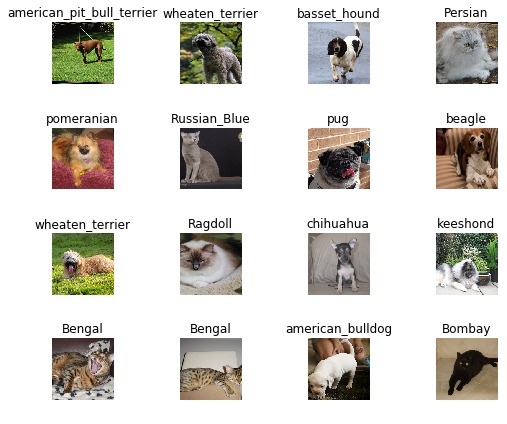

In [0]:
data.show_batch(rows=4, figsize=(7,6))

Print out all of the unique class names

In [0]:
print(data.classes)

['Abyssinian', 'Bengal', 'Birman', 'Bombay', 'British_Shorthair', 'Egyptian_Mau', 'Maine_Coon', 'Persian', 'Ragdoll', 'Russian_Blue', 'Siamese', 'Sphynx', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'boxer', 'chihuahua', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'miniature_pinscher', 'newfoundland', 'pomeranian', 'pug', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


Create a resnet34 model (CNN with 34 layers, pre trained on images of things), passing in the databunch. Print metrics

In [0]:
learn = create_cnn(data, models.resnet34, metrics=error_rate)

/usr/local/lib/python3.6/dist-packages/fastai/vision/learner.py:106: UserWarning: `create_cnn` is deprecated and is now named `cnn_learner`.
  warn("`create_cnn` is deprecated and is now named `cnn_learner`.")
Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 144433733.85it/s]


Learn with the databunch on the model. Printing out the metrics on each epoch. 4 epochs

In [0]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.384226,0.339205,0.100812,01:27
1,0.548155,0.238164,0.082544,01:27
2,0.341228,0.212517,0.073072,01:27
3,0.254603,0.203583,0.074425,01:28


Save the model in its current state so that it be used later

In [0]:
learn.save('stage-1')

Create a new Interpretation to interpret and view the results of the learnings

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

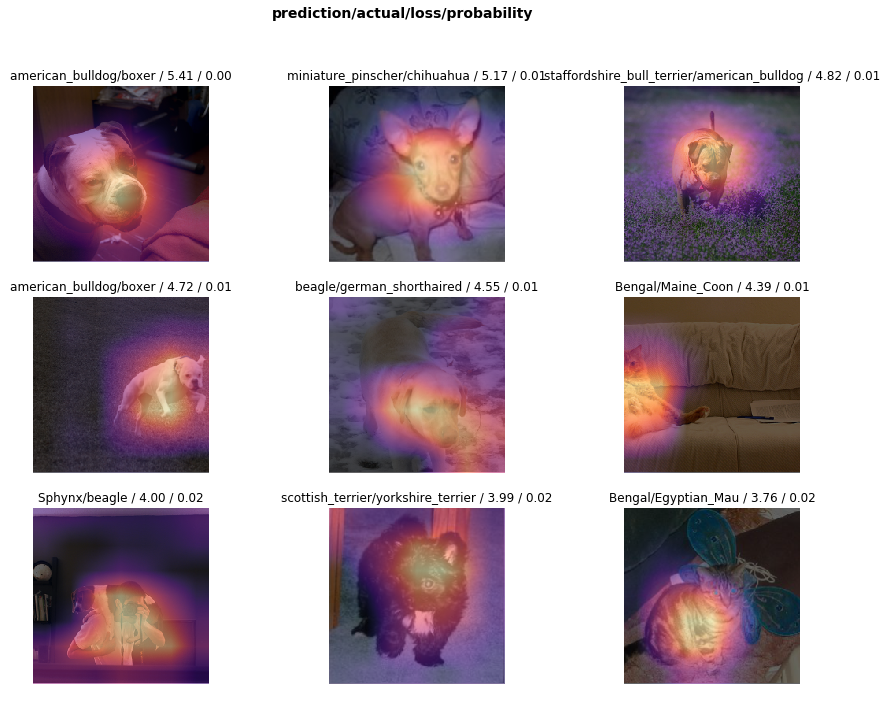

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

Shows the number of times things were mistaken. Here it is clear that the vast majority of the time the breeds matched up with eachother... so little confusion going on here

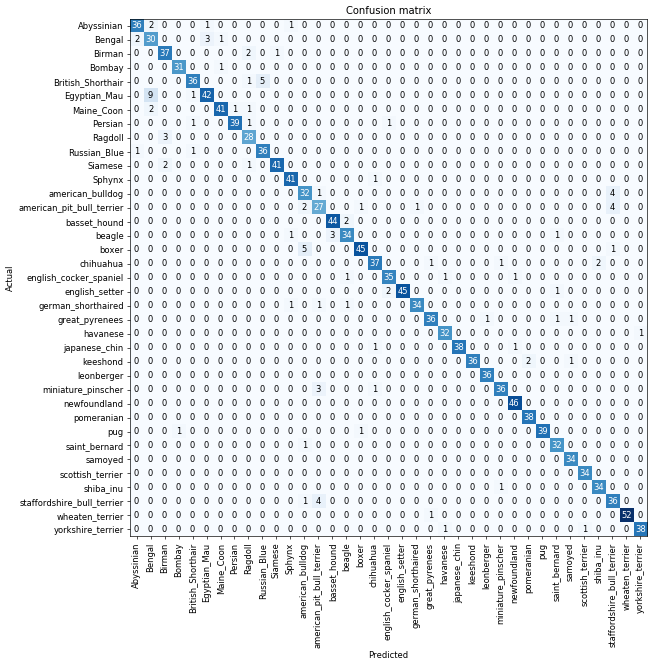

In [0]:
interp.plot_confusion_matrix(figsize=(15, 11), dpi=60)

Show the most confused categories

In [0]:
interp.most_confused(min_val=4)

[('Egyptian_Mau', 'Bengal', 9),
 ('British_Shorthair', 'Russian_Blue', 5),
 ('boxer', 'american_bulldog', 5),
 ('american_bulldog', 'staffordshire_bull_terrier', 4),
 ('american_pit_bull_terrier', 'staffordshire_bull_terrier', 4),
 ('staffordshire_bull_terrier', 'american_pit_bull_terrier', 4)]

## Unfreezing
Training the first group of layers after the last ones have been trained.

This can be seen as a refienment of our model.
Unfreezing the model allows us to train the first group of layers retrospectively to the later layers. The model came trained, so it didn't make sense to mess with the model that could already distinguish cats from lamposts, however, in order to achieve a smaller error rate, we will have to make the first group of layers more adapted to our particular problem.

In [0]:
learn.unfreeze()

The error rate increased... This is most likely due to the learning rate being too high...

In [0]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.494223,0.327472,0.100135,01:28


In [0]:
learn.load('stage-1')

Learner(data=ImageDataBunch;

Train: LabelList (5912 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
american_bulldog,basset_hound,Maine_Coon,Persian,havanese
Path: /root/.fastai/data/oxford-iiit-pet/images;

Valid: LabelList (1478 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
beagle,english_setter,english_setter,great_pyrenees,samoyed
Path: /root/.fastai/data/oxford-iiit-pet/images;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=

In [0]:
Inspecting the error rate

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


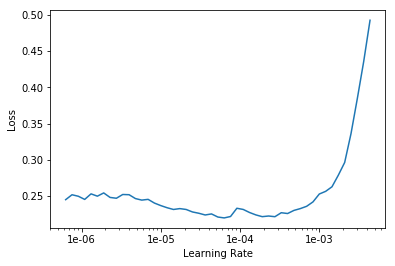

In [0]:
learn.recorder.plot() 

The leaning rate defaults to ~ 1e-3, and the plot shows, at this value the loss starts to dramatically increase. Choose a learning rate that is more suitable to the problem.

Can provide a range of learning rates, which get applied to each mini_batch.

In [0]:
learn.unfreeze()

In [0]:
learn.fit_one_cycle(2, max_lr=slice(1e-5,1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.236495,0.195316,0.067659,01:27
1,0.198755,0.185490,0.064953,01:27


Error rate dramatically decreases.